# <center>Hotel Booking Cancellation Prediction</center>

## Objective


<b>The objective of this project is to use Data Science and Machine Learning to devise a strategy to handle the hotel booking cancellation to reduce the loss in revenue. Hotel guest data and booking behaviour patterns are leveraged to create the model.</b>

## Importing the python libraries

In [1]:
# importing the python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# missing value imputation
from sklearn.impute import SimpleImputer

# feature discretization
from sklearn.preprocessing import KBinsDiscretizer

# Feature Selection

# removal of zero variance features
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest,chi2

# Model Development
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Model Evaluation
from sklearn import metrics
from sklearn.metrics import confusion_matrix

# suppressing warnings
import warnings
warnings.filterwarnings("ignore")

## Importing the Dataset

In [2]:
df = pd.read_csv("hotel_bookings.csv")

## Exploratory Data Analysis and Preprocessing

In [3]:
# dispalying the first 5 rows of data
df.head()

,hotel,is_canceled,lead_time,arrival_month_year,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,July 2015,2015,July,27,1,0,0,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,01-07-2015
1,Resort Hotel,0,737,July 2015,2015,July,27,1,0,0,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,01-07-2015
2,Resort Hotel,0,7,July 2015,2015,July,27,1,0,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,02-07-2015
3,Resort Hotel,0,13,July 2015,2015,July,27,1,0,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,02-07-2015
4,Resort Hotel,0,14,July 2015,2015,July,27,1,0,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,03-07-2015


In [4]:
df.shape

(119390, 33)

There are close to 120,000 observations and 33 features in the given dataset

In [5]:
# checking the data types
df.dtypes

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_month_year                 object
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                      

The given dataset has numeric and categorical columns

### Setting the display option to ensure feature visibility

In [6]:
pd.set_option('display.max_columns',None)

### Defining the Target and Independent Variables

In [7]:
# The target variable is 'is_canceled'
Y = df[['is_canceled']]

#  independent variables
X = df.drop(['is_canceled'],axis=1)

### Get the cancellation rate

In [8]:
Y.mean()

is_canceled    0.370416
dtype: float64

### Splitting features into Numerical and Categorical columns

In [9]:
# numerical features
num = X.select_dtypes(include = 'number')

# getting the object type columns
char = X.select_dtypes(include = 'object')

In [10]:
def unique_levels(x):
    '''
    This method returns the count of unique values present in the dataset for the column x
    Parameter: x - column name
    Returns: Count of unique values for column x
    '''
    x = x.value_counts().count()
    return x

In [11]:
# finding the count of unique values for each numerical column
df_value_counts = pd.DataFrame(num.apply(lambda x: unique_levels(x)))
df_value_counts

,0
lead_time,479
arrival_date_year,3
arrival_date_week_number,53
arrival_date_day_of_month,31
stays_in_weekend_nights,17
stays_in_week_nights,35
adults,14
children,5
babies,5
is_repeated_guest,2


In [12]:
## renaming the column name of df_value_counts
df_value_counts.columns = ['feature_levels']
df_value_counts.head()

,feature_levels
lead_time,479
arrival_date_year,3
arrival_date_week_number,53
arrival_date_day_of_month,31
stays_in_weekend_nights,17


In [13]:
# identifying all numerical values having less than 20 unique levels
slice1 = df_value_counts.loc[df_value_counts['feature_levels']<=20]
# get the index of the columns with levels <= 20
cat_list = slice1.index
#separating all numerical values having less than 20 unique levels
cat = num.loc[:,cat_list]


In [14]:
# setting the numerical data to hold only those columns having unique levels > 20
slice2 = df_value_counts.loc[df_value_counts['feature_levels']>20]
# index
num_list=slice2.index
num=num.loc[:,num_list]

In [15]:
num.shape

(119390, 10)

In [16]:
num.dtypes

lead_time                           int64
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_week_nights                int64
previous_bookings_not_canceled      int64
booking_changes                     int64
agent                             float64
company                           float64
days_in_waiting_list                int64
adr                               float64
dtype: object

In [17]:
# Concatencating the numerical data with levels <=20 with the categorical columns
char = pd.concat([char,cat],axis=1,join='inner')

In [18]:
char.dtypes

hotel                           object
arrival_month_year              object
arrival_date_month              object
meal                            object
country                         object
market_segment                  object
distribution_channel            object
reserved_room_type              object
assigned_room_type              object
deposit_type                    object
customer_type                   object
reservation_status              object
reservation_status_date         object
arrival_date_year                int64
stays_in_weekend_nights          int64
adults                           int64
children                       float64
babies                           int64
is_repeated_guest                int64
previous_cancellations           int64
required_car_parking_spaces      int64
total_of_special_requests        int64
dtype: object

In [19]:
char.head()

,hotel,arrival_month_year,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type,reservation_status,reservation_status_date,arrival_date_year,stays_in_weekend_nights,adults,children,babies,is_repeated_guest,previous_cancellations,required_car_parking_spaces,total_of_special_requests
0,Resort Hotel,July 2015,July,BB,PRT,Direct,Direct,C,C,No Deposit,Transient,Check-Out,01-07-2015,2015,0,2,0.0,0,0,0,0,0
1,Resort Hotel,July 2015,July,BB,PRT,Direct,Direct,C,C,No Deposit,Transient,Check-Out,01-07-2015,2015,0,2,0.0,0,0,0,0,0
2,Resort Hotel,July 2015,July,BB,GBR,Direct,Direct,A,C,No Deposit,Transient,Check-Out,02-07-2015,2015,0,1,0.0,0,0,0,0,0
3,Resort Hotel,July 2015,July,BB,GBR,Corporate,Corporate,A,A,No Deposit,Transient,Check-Out,02-07-2015,2015,0,1,0.0,0,0,0,0,0
4,Resort Hotel,July 2015,July,BB,GBR,Online TA,TA/TO,A,A,No Deposit,Transient,Check-Out,03-07-2015,2015,0,2,0.0,0,0,0,0,1


### Outlier Analysis of Numerical Features

In [20]:
num.describe(percentiles=[0.01,0.05,0.10,0.25,0.50,0.75,0.85,0.88,0.9,0.99])

,lead_time,arrival_date_week_number,arrival_date_day_of_month,stays_in_week_nights,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000
mean,104.011416,27.165173,15.798241,2.500302,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122
std,106.863097,13.605138,8.780829,1.908286,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000
1%,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000,16.000000,0.000000,0.000000
5%,0.000000,5.000000,2.000000,0.000000,0.000000,0.000000,1.000000,40.000000,0.000000,38.400000
10%,3.000000,8.000000,4.000000,1.000000,0.000000,0.000000,6.000000,40.000000,0.000000,50.000000
25%,18.000000,16.000000,8.000000,1.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000
50%,69.000000,28.000000,16.000000,2.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000
75%,160.000000,38.000000,23.000000,3.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000


### Capping and Flooring of outliers

In [21]:
def outlier_cap(x):
    '''This method removes all values below the 1st percentile and above the 99th percentile'''
    x=x.clip(lower=x.quantile(0.01))
    x=x.clip(upper=x.quantile(0.99))
    return(x)

In [22]:
# removing the very extreme outliers
num=num.apply(lambda x : outlier_cap(x))

In [23]:
num.describe(percentiles=[0.01,0.05,0.10,0.25,0.50,0.75,0.85,0.88,0.9,0.99])

,lead_time,arrival_date_week_number,arrival_date_day_of_month,stays_in_week_nights,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000
mean,103.409180,27.173943,15.798241,2.479211,0.060273,0.209574,86.008598,189.206373,1.606902,101.461251
std,104.600923,13.588582,8.780829,1.761267,0.376351,0.555245,108.591334,131.297172,9.760268,46.905036
min,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000,16.000000,0.000000,0.000000
1%,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000,16.000000,0.000000,0.000000
5%,0.000000,5.000000,2.000000,0.000000,0.000000,0.000000,1.000000,40.000000,0.000000,38.400000
10%,3.000000,8.000000,4.000000,1.000000,0.000000,0.000000,6.000000,40.000000,0.000000,50.000000
25%,18.000000,16.000000,8.000000,1.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000
50%,69.000000,28.000000,16.000000,2.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000
75%,160.000000,38.000000,23.000000,3.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000


### Missing Value Analysis

In [24]:
# Missing Value Analysis of numerical data
num.isnull().sum()

lead_time                              0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_week_nights                   0
previous_bookings_not_canceled         0
booking_changes                        0
agent                              16340
company                           112593
days_in_waiting_list                   0
adr                                    0
dtype: int64

<b>There are 16340 null entries for agent and 112593 null entries for company</b>

In [25]:
num.isnull().mean()

lead_time                         0.000000
arrival_date_week_number          0.000000
arrival_date_day_of_month         0.000000
stays_in_week_nights              0.000000
previous_bookings_not_canceled    0.000000
booking_changes                   0.000000
agent                             0.136862
company                           0.943069
days_in_waiting_list              0.000000
adr                               0.000000
dtype: float64

94% of the values for company is null. It is best to drop this column as retaining this column will lead to more guesses which can hinder our analysis.

13.68% of the values for agent is null. This needs to be handled

In [26]:
# Missing value analysis of categorical data
char.isnull().sum()

hotel                            0
arrival_month_year               0
arrival_date_month               0
meal                             0
country                        488
market_segment                   0
distribution_channel             0
reserved_room_type               0
assigned_room_type               0
deposit_type                     0
customer_type                    0
reservation_status               0
reservation_status_date          0
arrival_date_year                0
stays_in_weekend_nights          0
adults                           0
children                         4
babies                           0
is_repeated_guest                0
previous_cancellations           0
required_car_parking_spaces      0
total_of_special_requests        0
dtype: int64

There are 488 missing values for country feature 

In [27]:
char.isnull().mean()

hotel                          0.000000
arrival_month_year             0.000000
arrival_date_month             0.000000
meal                           0.000000
country                        0.004087
market_segment                 0.000000
distribution_channel           0.000000
reserved_room_type             0.000000
assigned_room_type             0.000000
deposit_type                   0.000000
customer_type                  0.000000
reservation_status             0.000000
reservation_status_date        0.000000
arrival_date_year              0.000000
stays_in_weekend_nights        0.000000
adults                         0.000000
children                       0.000034
babies                         0.000000
is_repeated_guest              0.000000
previous_cancellations         0.000000
required_car_parking_spaces    0.000000
total_of_special_requests      0.000000
dtype: float64

### Dropping features that have > 25% missing values

In [28]:
num = num.loc[:, num.isnull().mean() <= .25]

In [29]:
# Ensuring that fetures with more than 25% missing values have been dropped
num.isnull().mean()

#company  has been dropped

lead_time                         0.000000
arrival_date_week_number          0.000000
arrival_date_day_of_month         0.000000
stays_in_week_nights              0.000000
previous_bookings_not_canceled    0.000000
booking_changes                   0.000000
agent                             0.136862
days_in_waiting_list              0.000000
adr                               0.000000
dtype: float64

### Imputation of Missing Values

#### Missing Value Imputation for numerical data

In [30]:
# imputer will replace the NaN values with mean
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

# fit the imputer and transforming the numerical dataframe
num_1 = pd.DataFrame(imputer.fit_transform(num),index=num.index,columns=num.columns)

num_1.head()

,lead_time,arrival_date_week_number,arrival_date_day_of_month,stays_in_week_nights,previous_bookings_not_canceled,booking_changes,agent,days_in_waiting_list,adr
0,342.0,27.0,1.0,0.0,0.0,3.0,86.008598,0.0,0.0
1,444.0,27.0,1.0,0.0,0.0,3.0,86.008598,0.0,0.0
2,7.0,27.0,1.0,1.0,0.0,0.0,86.008598,0.0,75.0
3,13.0,27.0,1.0,1.0,0.0,0.0,304.000000,0.0,75.0
4,14.0,27.0,1.0,2.0,0.0,0.0,240.000000,0.0,98.0


In [31]:
# confirming that there are no missing values in num_1
num_1.isnull().mean()

lead_time                         0.0
arrival_date_week_number          0.0
arrival_date_day_of_month         0.0
stays_in_week_nights              0.0
previous_bookings_not_canceled    0.0
booking_changes                   0.0
agent                             0.0
days_in_waiting_list              0.0
adr                               0.0
dtype: float64

There are no more missing values in the numerical dataframe!!

#### Missing Value Imputation for categorical data

In [32]:
# using SimpleImputer to fill all the missing values with the mode (most frequently occuring) value
imputer=SimpleImputer(missing_values=np.nan, strategy='most_frequent')

# fit the imputer an transform the categorical data frame
char_1=pd.DataFrame(imputer.fit_transform(char),index=char.index,columns=char.columns)

In [33]:
# verifying that the missing values have been imputed
char_1.isnull().mean()

hotel                          0.0
arrival_month_year             0.0
arrival_date_month             0.0
meal                           0.0
country                        0.0
market_segment                 0.0
distribution_channel           0.0
reserved_room_type             0.0
assigned_room_type             0.0
deposit_type                   0.0
customer_type                  0.0
reservation_status             0.0
reservation_status_date        0.0
arrival_date_year              0.0
stays_in_weekend_nights        0.0
adults                         0.0
children                       0.0
babies                         0.0
is_repeated_guest              0.0
previous_cancellations         0.0
required_car_parking_spaces    0.0
total_of_special_requests      0.0
dtype: float64

## Feature Selection - Numerical Features

### Part 1: Remove Features with Zero Variance

In [34]:
# setting the variance threshold to 0 (indicating zero variance)
varselector= VarianceThreshold(threshold=0)

# fit the VarianceThreshold on the numerical data and transform it
varselector.fit_transform(num_1)

# get the columns with non zero variance and create a new dataframe
cols = varselector.get_support(indices=True)

num_2 = num_1.iloc[:,cols]

In [35]:
num_2.columns

Index(['lead_time', 'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_week_nights', 'previous_bookings_not_canceled',
       'booking_changes', 'agent', 'days_in_waiting_list', 'adr'],
      dtype='object')

### Part 2: Bivariate Analysis (Feature Discretization)

In [36]:
# The numerical data is being grouped into bins. As there are 10 bins, each bin will have a decile (10%) of data. 
discrete = KBinsDiscretizer(n_bins=10,encode='ordinal',strategy='quantile')

# storing the binned data into a new data frame with column name suffixed with Rank
num_binned = pd.DataFrame(discrete.fit_transform(num_2), index=num_2.index, columns=num_2.columns).add_suffix('_Rank')
num_binned.tail()

,lead_time_Rank,arrival_date_week_number_Rank,arrival_date_day_of_month_Rank,stays_in_week_nights_Rank,previous_bookings_not_canceled_Rank,booking_changes_Rank,agent_Rank,days_in_waiting_list_Rank,adr_Rank
119385,2.0,6.0,9.0,5.0,0.0,0.0,5.0,0.0,5.0
119386,6.0,6.0,9.0,5.0,0.0,0.0,2.0,0.0,9.0
119387,3.0,6.0,9.0,5.0,0.0,0.0,2.0,0.0,8.0
119388,6.0,6.0,9.0,5.0,0.0,0.0,4.0,0.0,5.0
119389,8.0,6.0,9.0,5.0,0.0,0.0,2.0,0.0,8.0


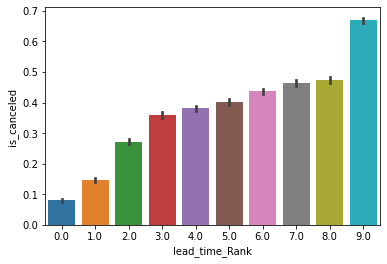

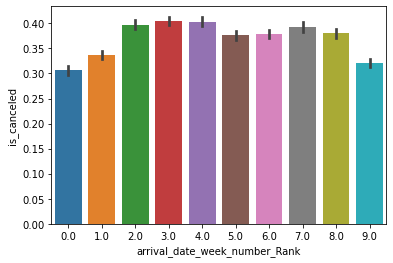

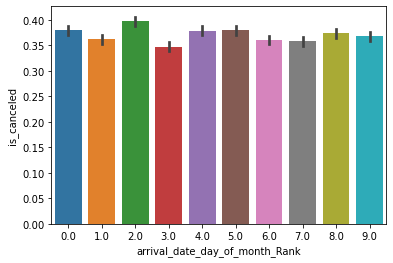

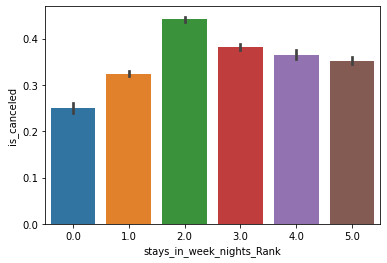

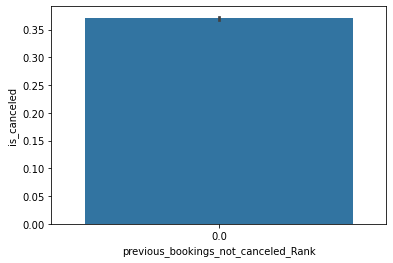

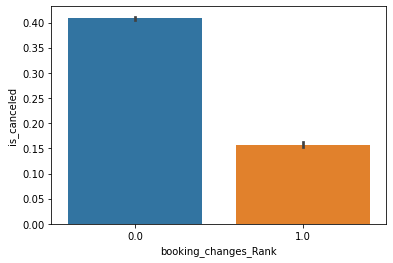

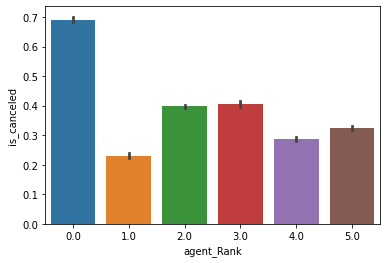

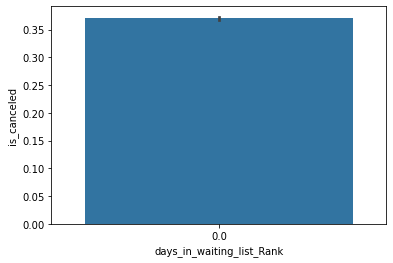

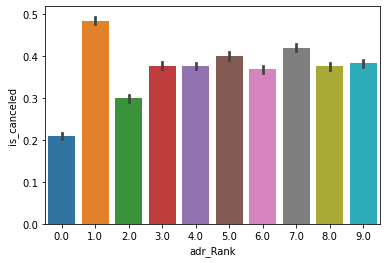

In [37]:
# Plotting for bi-variate analysis
# If the features show a slope such that some deciles are below the average event rate and some above, it indicates a strong slope
# Conclusion:If the slope is strong, it indicates that the feature is a good predictor -  it can clearly discriminate an event from a non event


# concatenating the Y with num_binned
X_bin_combined = pd.concat([Y,num_binned],axis=1,join='inner')

X_bin_combined['is_canceled'].mean()
# plotting the bivariate graph for each numerical feature
from numpy import mean
for col in (num_binned.columns):    
    plt.figure()
    #sns.lineplot(x=col, y=X_bin_combined['is_canceled'].mean(), data=X_bin_combined,color='red')
    sns.barplot(x=col, y="is_canceled", data=X_bin_combined, estimator=mean )
plt.show()

 - The feature 'previous_bookings_not_canceled' has been binned in a single rank. This indicates that there may not been a distinct difference between the values for this feature
 - Similarly, all the values for 'days_in_waiting_list' have fallen in a single rank
 - 'booking_changes' also have only 2 ranks

 - The descriptive statistics of these features need to be checked again and then we can convert these columns to indicators (with values 0 and 1) if needed

In [38]:
num_2['day_wait_ind']=np.where(num_2['days_in_waiting_list']>0,1,0)
num_2['previous_bookings_not_canceled_ind']=np.where(num_2['previous_bookings_not_canceled']>0,1,0)
num_2['booking_changes_ind']=np.where(num_2['booking_changes']>0,1,0)

In [39]:
# list of features which are not good predictors of the event
num_varlist=['adr','arrival_date_day_of_month','arrival_date_week_number','days_in_waiting_list','previous_bookings_not_canceled',
            'booking_changes']
num_2=num_2.drop(num_varlist,axis=1)

In [40]:
num_2.dtypes

lead_time                             float64
stays_in_week_nights                  float64
agent                                 float64
day_wait_ind                            int32
previous_bookings_not_canceled_ind      int32
booking_changes_ind                     int32
dtype: object

In [41]:
num_2.shape

(119390, 6)

### Part 3: Select K-Best features

In [42]:
# Selecting 4 best numerical featues for our model
selector = SelectKBest(chi2,k=4)

# fitting and transform
selector = SelectKBest(chi2, k=4)
selector.fit_transform(num_2, Y)

# getting the 4 best features
cols = selector.get_support(indices=True)

# creating a new data frame with selected best numerical features
select_features_df_num = num_2.iloc[:,cols]

## Feature Selection - Categorical Features

In [43]:
# Merging the categorical features and target variable for Bivariate Analysis
X_char_merged =pd.concat([Y,char], axis=1, join='inner')

### Part-1: Bi Variate Analysis

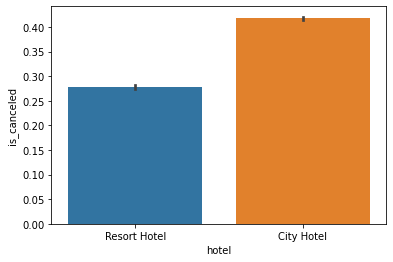

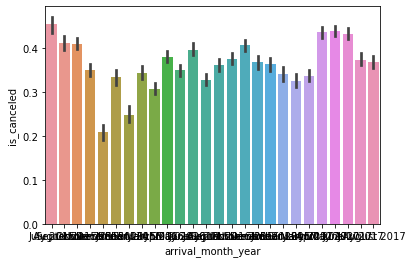

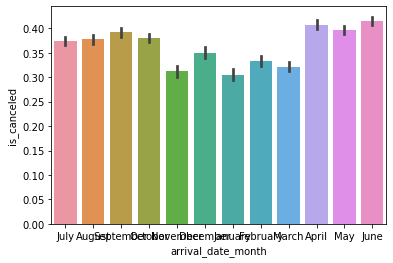

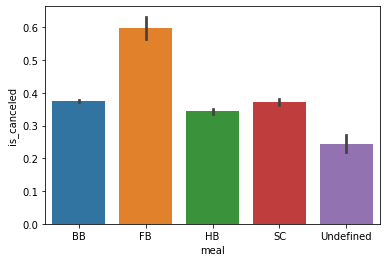

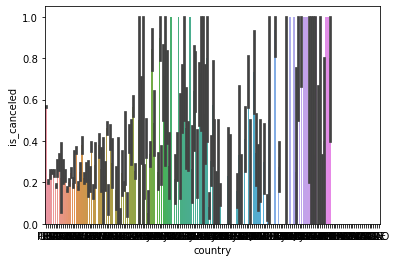

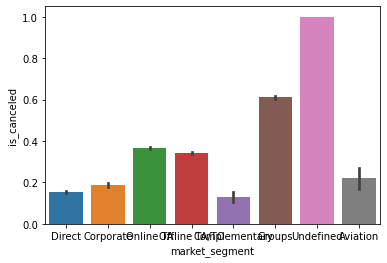

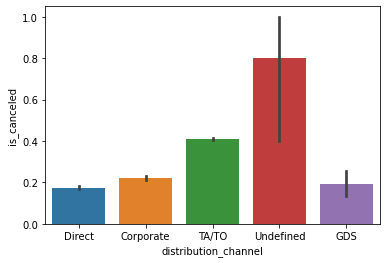

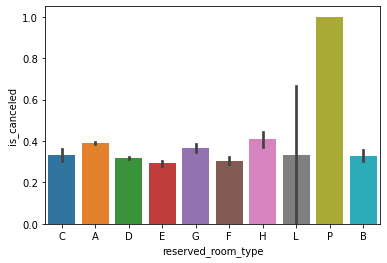

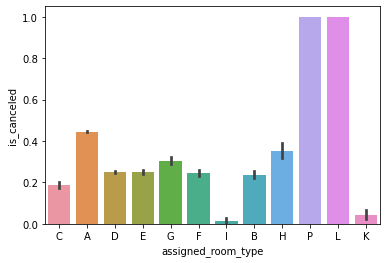

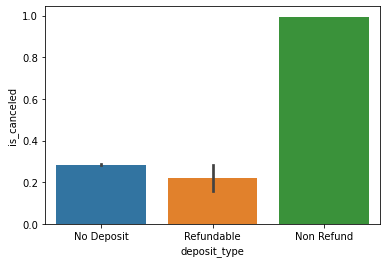

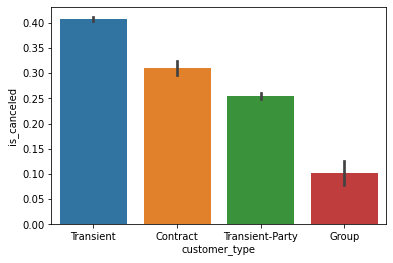

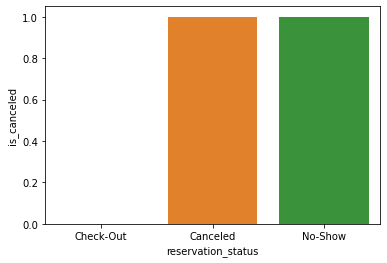

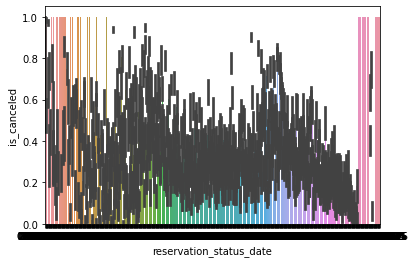

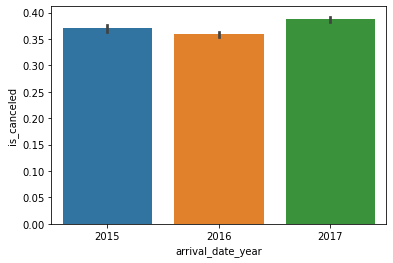

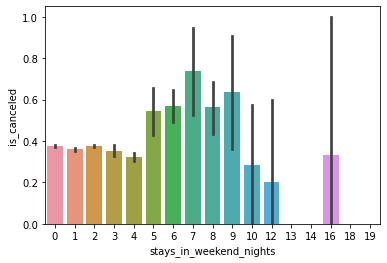

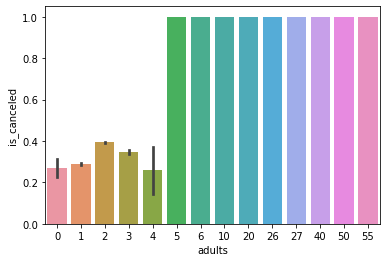

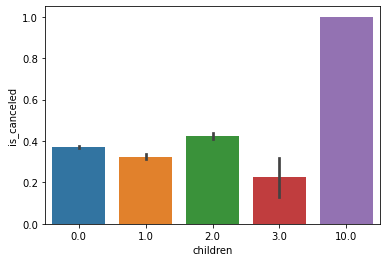

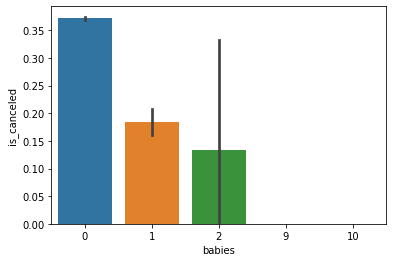

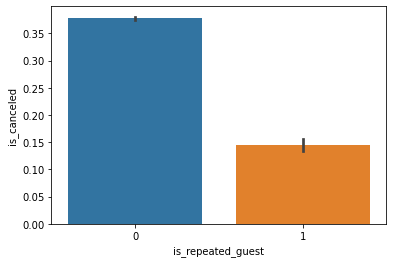

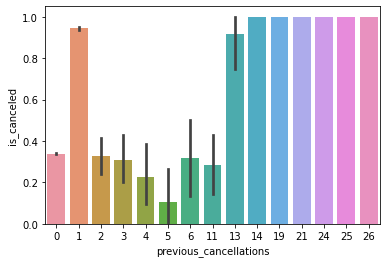

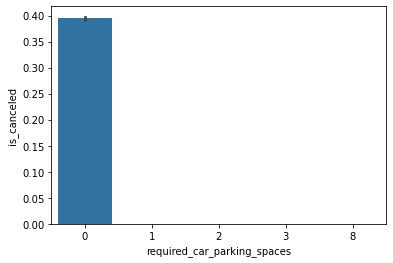

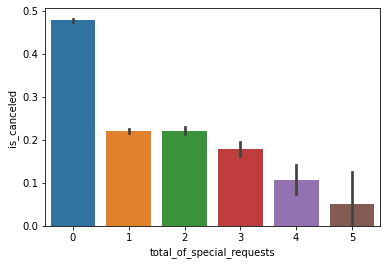

In [44]:
for col in char:
    plt.figure()
    sns.barplot(x=col, y="is_canceled",data = X_char_merged, estimator=mean )
plt.show()    

In [45]:
# dropping fetures which do not seem to be good predictors
charlist=['arrival_date_month','country','reserved_room_type','assigned_room_type','reservation_status','reservation_status_date','arrival_date_year']
char_1=char_1.drop(charlist,axis=1)

In [46]:
# converting the categorical variables into indicatos/numerical variables
X_char_dum = pd.get_dummies(char_1, drop_first = True) # there will be n-1 levels
X_char_dum.shape

(119390, 107)

### Part-2 : Selecting K-Best

In [47]:
# choosing the 100 best features
selector = SelectKBest(chi2, k=100)
selector.fit_transform(X_char_dum, Y)

# fetching the 100 best featues
cols = selector.get_support(indices=True)
# creating a new dataframe with the 100 best features
select_features_df_char = X_char_dum.iloc[:,cols]

## Model Development

### Creating the master training dataset 

In [48]:
# creating the master training datset by combining the selected numerical features and categorical features
X_all=pd.concat([select_features_df_char,select_features_df_num],axis=1,join="inner")

### Train Test Split

In [49]:
# Splitting the data into Train and Test Split
# The ratio of train: test is 70:30
X_train, X_test, y_train, y_test=train_test_split(X_all, Y, test_size=0.3, random_state=20)

In [50]:
print("Shape of Training Data",X_train.shape)
print("Shape of Testing Data",X_test.shape)
print("Cancellation Rate in Training Data",y_train.mean())
print("Cancellation Rate in Testing Data",y_test.mean())

Shape of Training Data (83573, 104)
Shape of Testing Data (35817, 104)
Cancellation Rate in Training Data is_canceled    0.370443
dtype: float64
Cancellation Rate in Testing Data is_canceled    0.370355
dtype: float64


In the above split, the cancellation rate for training and testing set is approximately the same (approx 37%). This indicates a good split

In [51]:
# Non linearity has been observed in the feature relationships. So Trees can be used for model building
# There are few options to consider among tree methods
# Decision Tree - White Box method with completely explainable set of rules
# Random Forest  - Ensemble Methods with Bagging
# GBM/XGBoost - Ensemble Methods with Boosting

In [52]:
# Building a Decision Tree Model
dtree = DecisionTreeClassifier(criterion='gini',random_state=20)

In [53]:
# Using GridSearchCV to find the best parameters for DecisionTree
np.random.seed(44)
param_dist = {'max_depth': [3, 5, 6, 7], 'min_samples_split': [140,280,420,560,700] }
tree_grid = GridSearchCV(dtree, cv = 10, param_grid=param_dist,n_jobs = 3)
tree_grid.fit(X_train,y_train) 
print('Best Parameters using grid search: \n', tree_grid.best_params_)

Best Parameters using grid search: 
 {'max_depth': 7, 'min_samples_split': 140}


In [54]:
# Fitting the Decision Tree Classifier with the parameters returned by Grid Search CV
dtree=DecisionTreeClassifier(criterion='gini', random_state=20,max_depth=7, min_samples_split=140)
dtree.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=7, min_samples_split=140, random_state=20)

In [55]:
# Building a Random Forest Model with same paramteres as that of Decision Tree Classifier
rf=RandomForestClassifier(criterion='gini',random_state=20,max_depth=7,min_samples_split=140)
rf.fit(X_train,y_train)

RandomForestClassifier(max_depth=7, min_samples_split=140, random_state=20)

In [56]:
# Building a Gradient Boosting Model with same paramteres as that of Decision Tree Classifier
gbm=GradientBoostingClassifier(criterion='mse',random_state=20,max_depth=7,min_samples_split=140)
gbm.fit(X_train,y_train)

GradientBoostingClassifier(criterion='mse', max_depth=7, min_samples_split=140,
                           random_state=20)

In [57]:
# Model Evaluation

y_pred_tree=dtree.predict(X_test)
y_pred_rf=rf.predict(X_test)
y_pred_gbm=gbm.predict(X_test)

In [58]:
# Evaluating the predictions of the Decision Tree Classifier
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_tree))
print("Precision",metrics.precision_score(y_test,y_pred_tree))
print("Recall",metrics.recall_score(y_test,y_pred_tree))
print("f1_score",metrics.f1_score(y_test,y_pred_tree))

Accuracy: 0.7844878130496692
Precision 0.7297051027170312
Recall 0.6640784018092725
f1_score 0.6953467261317441


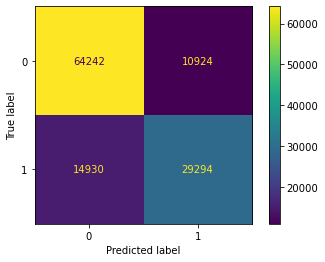

In [59]:
# Plotting the confusion matrix
metrics.plot_confusion_matrix(dtree,X_all,Y)

In [60]:
# Evaluating the Random Forest Classifier
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_rf))
print("Precision",metrics.precision_score(y_test,y_pred_rf))
print("Recall",metrics.recall_score(y_test,y_pred_rf))
print("f1_score",metrics.f1_score(y_test,y_pred_rf))

Accuracy: 0.7684898232682804
Precision 0.9979971960745043
Recall 0.37565020731247645
f1_score 0.5458429181728558


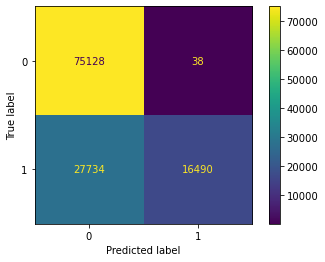

In [61]:
# plotting the confusion matrix
metrics.plot_confusion_matrix(rf,X_all,Y)

In [62]:
# Evaluating the GBM
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_gbm))
print("Precision",metrics.precision_score(y_test,y_pred_gbm))
print("Recall",metrics.recall_score(y_test,y_pred_gbm))
print("f1_score",metrics.f1_score(y_test,y_pred_gbm))

Accuracy: 0.8379819638719044
Precision 0.8577867280398926
Recall 0.6743309460987561
f1_score 0.7550753387076351


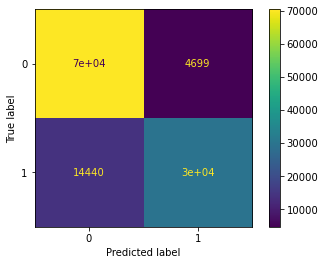

In [63]:
# Confusion matrix

metrics.plot_confusion_matrix(gbm,X_all,Y)

### Decile Method of measuring the KS Statistic

 - Kolmogorov-Smirnov (KS) Statistics is one of the most important metrics used for validating predictive models. 
 - KS statistic compares the cumulative distribution of events and non-events and KS is where there is a maximum difference between the two distributions.
 - It helps us to understand how well our predictive model is able to discriminate between events and non-events

Decile Method to measure KS Statistic


 - This method is the most common way to calculate KS statistic for validating binary predictive model.
 - There are two variables for calculating KS. One is dependent variable which should be binary. Second one is predicted probability score which is generated from statistical model.
 - Create deciles based on predicted probability columns which means dividing probability into 10 parts. First decile should contain highest probability score. 
 - Calculate the cumulative % of events and non-events in each decile and then compute the difference between these two cumulative distribution. This is the KS score
 - KS is where the difference is maximum
 - If KS is in top 3 decile and score/value of KS is above 40, it is considered a good predictive model.
 - At the same time it is important to validate the model by checking other performance metrics as well to confirm that model is not suffering from overfitting problem

In [64]:
# fetching the predicted probabilities of event 
y_pred_prob = gbm.predict_proba(X_all)[:, 1]

# creating a new data frame with predicted probabilities of event
df['y_pred_P']=pd.DataFrame(y_pred_prob)

# converting the predicted probabilites into deciles
df['P_Rank_dtree']=pd.qcut(df['y_pred_P'].rank(method='first').values,10,duplicates='drop').codes+1

# grouping the actual results
rank_df_actuals=df.groupby('P_Rank_dtree')['is_canceled'].agg(['count','mean'])

In [65]:
# grouping the predicted results
rank_df_predicted=df.groupby('P_Rank_dtree')['y_pred_P'].agg(['mean'])
rank_df_actuals=pd.DataFrame(rank_df_actuals)

# renaming the column mean to Actual Event Rate
rank_df_actuals.rename(columns={'mean':'Actutal_event_rate'},inplace=True)

rank_df_predicted=pd.DataFrame(rank_df_predicted)
# renaming the column mean to Predicted Event Rate
rank_df_predicted.rename(columns={'mean':'Predicted_event_rate'},inplace=True)

# concatenating the actual and predicted dataframes
rank_df=pd.concat([rank_df_actuals,rank_df_predicted],axis=1,join="inner")

# sorting the ranks in descending order
sorted_rank_df=rank_df.sort_values(by='P_Rank_dtree',ascending=False)

# calculating the total number of events
sorted_rank_df['N_events']=rank_df['count']*rank_df['Actutal_event_rate']

# computing the cumulative sum of events
sorted_rank_df['cum_events']=sorted_rank_df['N_events'].cumsum()

sorted_rank_df['event_cap']=sorted_rank_df['N_events']/max(sorted_rank_df['N_events'].cumsum())

# cumulative event rate
sorted_rank_df['cum_event_cap']=sorted_rank_df['event_cap'].cumsum()

# computing the cumulative sum of non-events
sorted_rank_df['N_non_events']=sorted_rank_df['count']-sorted_rank_df['N_events']
sorted_rank_df['cum_non_events']=sorted_rank_df['N_non_events'].cumsum()
sorted_rank_df['non_event_cap']=sorted_rank_df['N_non_events']/max(sorted_rank_df['N_non_events'].cumsum())
# cumulative non_event rate
sorted_rank_df['cum_non_event_cap']=sorted_rank_df['non_event_cap'].cumsum()

# difference between the cumulative event rate and cumulative non event rate
sorted_rank_df['KS']=round((sorted_rank_df['cum_event_cap']-sorted_rank_df['cum_non_event_cap']),4)

sorted_rank_df['random_cap']=sorted_rank_df['count']/max(sorted_rank_df['count'].cumsum())
sorted_rank_df['cum_random_cap']=sorted_rank_df['random_cap'].cumsum()
sorted_reindexed=sorted_rank_df.reset_index()
sorted_reindexed['Decile']=sorted_reindexed.index+1

# Calculating the lift
sorted_reindexed['Lift_over_Avg']=sorted_reindexed['Actutal_event_rate']/(max(sorted_reindexed['N_events'].cumsum())/max(sorted_reindexed['count'].cumsum()))
sorted_reindexed

,P_Rank_dtree,count,Actutal_event_rate,Predicted_event_rate,N_events,cum_events,event_cap,cum_event_cap,N_non_events,cum_non_events,non_event_cap,cum_non_event_cap,KS,random_cap,cum_random_cap,Decile,Lift_over_Avg
0,10,11939,1.000000,0.994503,11939.0,11939.0,0.269967,0.269967,0.0,0.0,0.000000,0.000000,0.2700,0.1,0.1,1,2.699665
1,9,11939,0.896641,0.851683,10705.0,22644.0,0.242063,0.512030,1234.0,1234.0,0.016417,0.016417,0.4956,0.1,0.2,2,2.420631
2,8,11939,0.655583,0.606775,7827.0,30471.0,0.176985,0.689015,4112.0,5346.0,0.054706,0.071123,0.6179,0.1,0.3,3,1.769853
3,7,11939,0.418712,0.400558,4999.0,35470.0,0.113038,0.802053,6940.0,12286.0,0.092329,0.163452,0.6386,0.1,0.4,4,1.130382
4,6,11939,0.292822,0.301669,3496.0,38966.0,0.079052,0.881105,8443.0,20729.0,0.112325,0.275776,0.6053,0.1,0.5,5,0.790521
5,5,11939,0.194991,0.217743,2328.0,41294.0,0.052641,0.933746,9611.0,30340.0,0.127864,0.403640,0.5301,0.1,0.6,6,0.526411
6,4,11939,0.127230,0.151770,1519.0,42813.0,0.034348,0.968094,10420.0,40760.0,0.138627,0.542266,0.4258,0.1,0.7,7,0.343479
7,3,11939,0.076723,0.103709,916.0,43729.0,0.020713,0.988807,11023.0,51783.0,0.146649,0.688915,0.2999,0.1,0.8,8,0.207127
8,2,11939,0.037440,0.065701,447.0,44176.0,0.010108,0.998915,11492.0,63275.0,0.152888,0.841803,0.1571,0.1,0.9,9,0.101076
9,1,11939,0.004020,0.017274,48.0,44224.0,0.001085,1.000000,11891.0,75166.0,0.158197,1.000000,0.0000,0.1,1.0,10,0.010854


### Plotting the Gains Chart, Lift over average chart

<AxesSubplot:xlabel='Decile', ylabel='cum_non_event_cap'>

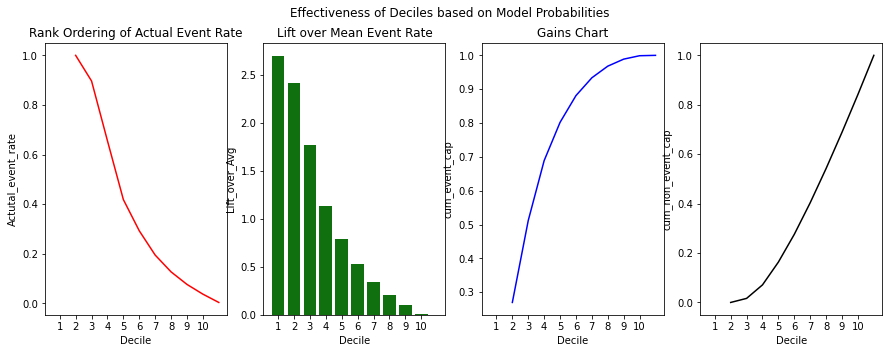

In [66]:
fig, axes = plt.subplots(1, 4, sharex=True, figsize=(15,5))
fig.suptitle('Effectiveness of Deciles based on Model Probabilities')
axes[0].set_title('Rank Ordering of Actual Event Rate')
axes[1].set_title('Lift over Mean Event Rate')
axes[2].set_title('Gains Chart')
sns.lineplot(ax=axes[0],  x="Decile", y="Actutal_event_rate", data=sorted_reindexed,color='red')
sns.barplot(ax=axes[1],  x="Decile", y="Lift_over_Avg", data=sorted_reindexed,color='green')
sns.lineplot(ax=axes[2],  x="Decile", y="cum_event_cap", data=sorted_reindexed,color='blue')
sns.lineplot(ax=axes[3],  x="Decile", y="cum_non_event_cap", data=sorted_reindexed,color='black')

## Machine Learning Strategy

A- Audience
P - Prioritization
T - Treatment

### Audience

In [67]:
# Classifying the hotel bookings as Bottom 7 and Top 3
# Top3 are higly likely to cancel the booking
# Bottom 7 are less likely to make a cancellation
df['Predicted_cancel_Rank']=np.where(df['P_Rank_dtree']<8,"Bottom7","Top3")
df.Predicted_cancel_Rank.value_counts()

Bottom7    83573
Top3       35817
Name: Predicted_cancel_Rank, dtype: int64

In [71]:
# we are interested in only the top 3 groups
df_top3=df.loc[df['Predicted_cancel_Rank']=='Top3',:]

### Prioritization

- <b>lead_time</b> is chosen as the <b>Engagement metric</b>

- <b>ADR</b> is chosen as the <b>Value Metric</b>

In [70]:
# converting the data into deciles based on lead time
df['lead_time_RANK']=pd.qcut(df['lead_time'].rank(method='first').values,10,duplicates='drop').codes+1
df.Predicted_cancel_Rank.value_counts()

Bottom7    83573
Top3       35817
Name: Predicted_cancel_Rank, dtype: int64

Out of the total, 83573 observations are in Bottom 7 and 35817 are in the top 3 groups that are likely to cancel

In [72]:
# computing the min_lead_time, average_lead_time and max_lead_time for each decile
df.groupby('lead_time_RANK')['lead_time'].agg(['min','mean','max'])

,min,mean,max
lead_time_RANK,,,
1,0,0.652735,3
2,3,6.449703,11
3,11,18.337465,26
4,26,35.099757,45
5,45,56.680291,69
6,69,83.823603,99
7,99,117.566044,138
8,138,160.550130,184
9,184,219.433286,265


In [73]:
# The average lead time of the total population is:
df.lead_time.mean()

104.01141636652986

In [74]:
# In the above deciles, rank >= 7 have their average lead time > the average lead_time of entire population
df['lead_time_segment']=np.where(df['lead_time_RANK']>=7,"High Lead Time","Low Lead Time")
df.lead_time_segment.value_counts()

Low Lead Time     71634
High Lead Time    47756
Name: lead_time_segment, dtype: int64

In [75]:
# grouping the data into deciles based on ADR
df['adr_RANK']=pd.qcut(df['adr'].rank(method='first').values,10,duplicates='drop').codes+1

In [76]:
# computing the min, average(ADR) and max(ADR) for each decile
df.groupby('adr_RANK')['adr'].agg(['min','mean','max'])

,min,mean,max
adr_RANK,,,
1,-6.38,32.638938,50.00
2,50.00,59.250104,64.00
3,64.00,69.332909,75.00
4,75.00,79.526233,85.00
5,85.00,89.482808,94.56
6,94.59,99.285965,105.00
7,105.00,111.376652,118.15
8,118.15,125.793015,135.00
9,135.00,147.667347,164.00


In [77]:
# The average ADR 
df.adr.mean()

101.83112153446453

In [78]:
# Classifying the data as High ADR and Low ADR
# from the ADR deciles rank >=7 have higher mean ADR
df['adr_segment']=np.where(df['adr_RANK']>=7,"High ADR","Low ADR")
df.adr_segment.value_counts()

Low ADR     71634
High ADR    47756
Name: adr_segment, dtype: int64

In [79]:
pd.crosstab(index=df['adr_segment'], columns=df['lead_time_segment'],values=df['adr'],aggfunc='mean')

lead_time_segment,High Lead Time,Low Lead Time
adr_segment,,
High ADR,141.203654,151.099370
Low ADR,74.960245,69.300239


In [85]:
pd.crosstab(index=df['adr_segment'], columns=df['lead_time_segment'],values=df['is_canceled'],aggfunc='mean')

lead_time_segment,High Lead Time,Low Lead Time
adr_segment,,
High ADR,0.482231,0.320037
Low ADR,0.528775,0.247969


The High Lead Time, Low ADR customers have highest priority. 
The Second Highest Prority is for High Lead Time, High ADR and 
The 3rd highes priority is for Low Lead time and High ADR

### Treatment

Analyzing how the services are used by the customers in top 3 groups of highly likely cancellations

In [82]:
service_list=['stays_in_weekend_nights','total_of_special_requests','reserved_room_type']

In [83]:
df_top3_services=df_top3[service_list]

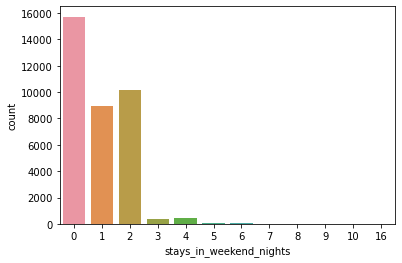

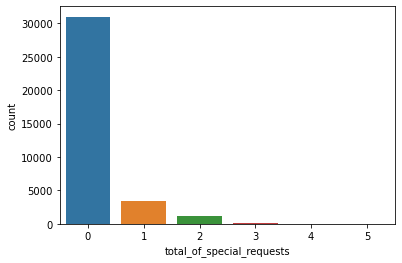

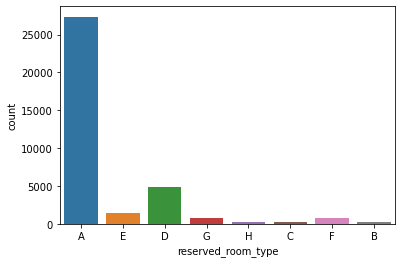

In [84]:
for col in (df_top3_services.columns):
    plt.figure()
    sns.countplot(x=col,data=df_top3_services)
plt.show()

In [ ]:
- Most cancellations occur in booking cases where there is no stay in weekend_nights. If some offers are made to ensure that these people opt for weekend stay, then cancellations will reduce
- Maximum number of cancellations occur in cases where the people do not opt for special requests. If these people are given special requests, cancellations will reduce
- Cancellations are more in cases where requests are made for Room type A or Room type D. If an upgrade is offered, cancellations can reduce. 